In [1]:
import pandas as pd
from dfply import *
import sys
from sshtunnel import SSHTunnelForwarder
import logging
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import time
from tqdm import tqdm
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈
import src.subjectlist_alignment.imputation as imp  # 결측치 채우는 모듈
import src.subjectlist_alignment.reintubation as rnt  # 재삽관
import src.subjectlist_alignment.subject_classification as cls  # 결측치 채우는 모듈
import src.utils.utils as utils  # 결측치 채우는 모듈

In [2]:
df = pd.read_csv('../outputs/subjectlist1.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', 'reintubation_eventtime', 'dischtime', 'deathtime'])
df

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,2230.0,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,5419.0,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,3477.0,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,3930.0,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,10005.0,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,8416.0,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure
8999,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,4269.0,NaT,NaN,False,True,NaN,15646.0,NaN,221,nonfailure
9000,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,4201.0,NaT,NaN,False,True,NaN,7525.0,NaN,11,nonfailure
9001,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,1155.0,NaT,NaN,True,True,NaN,20290.0,NaN,11,nonfailure


In [3]:
paired_df = pd.read_csv('../outputs/paired_df.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime'])
paired_df = cls.create_stay_id(paired_df)
paired_df

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2
9004,19997367,20617667,35616526,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3
9005,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,1
9006,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1


In [4]:
ventilation = pd.read_csv('../outputs/ventilation.csv', index_col=0, parse_dates=['starttime', 'endtime'])
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']   # Invasive 만 사용
ventilation_df

,stay_id,starttime,endtime,ventilation_status
0,30000153,2174-09-29 12:01:00,2174-09-29 20:00:00,InvasiveVent
2,30000213,2162-06-21 05:45:00,2162-06-21 17:35:00,InvasiveVent
5,30001148,2156-08-30 14:50:00,2156-08-30 18:00:00,InvasiveVent
12,30001656,2177-03-15 17:32:00,2177-03-16 12:00:00,InvasiveVent
14,30001947,2162-12-26 19:00:00,2162-12-27 09:19:00,InvasiveVent
...,...,...,...,...
111224,39997753,2110-09-11 23:00:00,2110-09-12 14:00:00,InvasiveVent
111226,39998012,2133-02-03 15:00:00,2133-02-08 16:00:00,InvasiveVent
111227,39998622,2135-02-11 18:15:00,2135-02-14 08:00:00,InvasiveVent
111228,39998622,2135-02-17 09:00:00,2135-02-18 08:00:00,InvasiveVent


,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2
9004,19997367,20617667,35616526,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3
9005,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,1
9006,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1


In [43]:
def init_marker(df):
    """
    결측치 처리 전에 'impute_marker'라는 칼럼을 생성. 어떤 결측값이 대체될 경우 이 칼럼에 마킹 됨.
    """
    df['marker'] = None

    return df


def insert_marker(row, log):
    """
    결측치 대체 등의 작업이 이루어진 행의 'marker' 칼럼에 수행된 작업 내용을 기입.
    """

    # 먼저, 'marker' 칼럼이 존재하는지 확인.
    if 'marker' not in row:
        print("Warning: 'marker' column not found. No action taken.")
        return row

    # 먼저, 행의 'marker' 칼럼이 비었는지 확인. 
    if pd.isna(row['marker']) or row['marker'] == None:
        # 'marker'가 비었으면 새로운 값 입력.
        row['marker'] = [log]
    else:
        # 'marker'가 비어있지 않으면 내용 추가.
        if not isinstance(row['marker'], list):   # 이미 기입된 값이 리스트가 아니라면 리스트로 변환
            row['marker'] = [row['marker']]   
        row['marker'].append(log)

    return row
 
 
def find_approx_single_vent(ventilation_df, row):
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return None

    results = {'original_times': None, 'candidate_times': None, 'stay_ids': None}
    
    stayid = row['stay_id']  # Directly use the unified 'stay_id' column
    target_time = 'endtime' if pd.isnull(row['extubationtime']) else 'starttime'
    known_time = row['intubationtime'] if target_time == 'endtime' else row['admittime']
    compare_time = row['dischtime'] if target_time == 'endtime' else row['extubationtime']

    results['original_times'] = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}
    
    candidates = ventilation_df[ventilation_df['stay_id'] == stayid]
    candidates = candidates[(candidates[target_time] > known_time) & (candidates[target_time] < compare_time)]

    if len(candidates) > 1:
        candidates['time_diff'] = (candidates[target_time] - known_time).abs()
        min_diff = candidates['time_diff'].min()
        closest_candidates = candidates[candidates['time_diff'] == min_diff]

        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"

        results['candidate_times'] = {corrected_time_type: [pd.Timestamp(time) for time in closest_candidates[target_time].values]}
        results['stay_ids'] = closest_candidates['stay_id'].values.tolist()

    elif len(candidates) == 1:
        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"
        results['candidate_times'] = {corrected_time_type: pd.Timestamp(candidates[target_time].values[0])}
        results['stay_ids'] = candidates['stay_id'].values[0]

    else:
        print("No candidate rows found.")

    return results if results['candidate_times'] else None



def find_best_candidate_for_imputation(ventilation_df, row, prev_row=None, next_row=None):
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return []

    results = []
    stay_id = row['stay_id']  # Directly use the unified 'stay_id' column

    if pd.isnull(row['intubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['starttime'] < row.get('extubationtime', np.inf)) &
                                    (ventilation_df['starttime'] > prev_row.get('extubationtime', row['admittime']))]

        if not candidates.empty:
            candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('intubationtime', candidates.loc[best_candidate_idx, 'starttime'], candidates.loc[best_candidate_idx, 'stay_id']))

    elif pd.isnull(row['extubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['endtime'] > row.get('intubationtime', -np.inf)) &
                                    (ventilation_df['endtime'] < next_row.get('intubationtime', row['dischtime']))]

        if not candidates.empty:
            candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('extubationtime', candidates.loc[best_candidate_idx, 'endtime'], candidates.loc[best_candidate_idx, 'stay_id']))

    return results



def process_ventilation_sequences(ventilation_df, group):
    """
    한 환자(=group)의 ventilation 이벤트를 처리하여 누락된 데이터에 대한 최적의 후보를 찾습니다.
    intubationtime과 extubationtime이 모두 존재하는 행은 건너뜁니다.
    """
    imputation_candidates = []

    for idx, row in group.iterrows():
        # 이번 행에 결측 없는 경우 다음 행으로 이동
        if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
            continue

        prev_row = group[group['seq_num'] == row['seq_num'] - 1].iloc[0] if row['seq_num'] > 1 else pd.Series()
        next_row = group[group['seq_num'] == row['seq_num'] + 1].iloc[0] if row['seq_num'] < group['seq_num'].max() else pd.Series()

        current_pair = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}

        if row.get('reint_marker', False):
            candidates = find_best_candidate_for_imputation(ventilation_df, row, prev_row, next_row)
            if candidates:
                # 오리지널 행과 후보군 함께 저장 (비교 위해)
                for time_type, time_value, stay_id in candidates:
                    imputation_candidate = {
                        'index': idx,
                        'current_pair': current_pair,
                        'candidate': (time_type, time_value),
                        'stay_id': stay_id  # Include stay_id for each candidate
                    }
                    imputation_candidates.append(imputation_candidate)
    return imputation_candidates



def ventilation_search(ventilation_df, subject_df):
    """
    ventilation 테이블을 이용해 결측된 삽관/발관 시간을 찾는 메인 함수.
    """

    grouped_df = subject_df.groupby(['subject_id', 'hadm_id'])

    single_row_results_list = []
    multirow_candidates_list = []

    for (subject_id, hadm_id), group in grouped_df:
        if len(group) == 1:
            # 1번째 칼럼 인덱스로 활용
            index = group.index[0]  # 데이터프레임 넘버링 되어 있어야 함.
            single_row = group.iloc[0]
            single_row_results = find_approx_single_vent(ventilation_df, single_row)
            if single_row_results:  # 결과가 Null이 아닌 경우 (즉, 대체 가능한 값이 있는 경우)
                single_row_results_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': [{
                        'index': index,
                        'current_pair': single_row_results['original_times'],
                        'candidates': [(key, val) for key, val in single_row_results['candidate_times'].items()],
                        'stay_ids': single_row_results['stay_ids']
                    }]
                })
        
        elif len(group) > 1:
            multirow_candidates = process_ventilation_sequences(ventilation_df, group)
            if multirow_candidates:  # 대체 가능한 값이 있는지 확인
                multirow_candidates_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': multirow_candidates
                })
    
    return single_row_results_list, multirow_candidates_list


def check_for_multiple_candidates(candidate_list):
    """
    결측이 필요한 행 중에서 후보군이 2 이상 있는 케이스 확인
    
    Parameters:
    - candidate_list: 후보군이 저장된 리스트
    
    Returns:
    - 2개 이상의 후보군이 있는 행 넘버
    """
    rows_with_multiple_candidates = []
    for entry in candidate_list:
        for candidate_info in entry['candidates']:
            if len(candidate_info['candidates']) > 1:  # More than one candidate found
                print(f"Multiple candidates found for row index {candidate_info['index']}: {candidate_info['candidates']}")
                rows_with_multiple_candidates.append(candidate_info['index'])
    return rows_with_multiple_candidates


# def impute_candidates(df, single_row_results_list, multirow_candidates_list):
#     """
#     DataFrame에 있는 결측된 intubationtime 또는 extubationtime을 선택된 후보값으로 대체하고,
#     'marker' 칼럼에 로그를 남깁니다. 다중 후보가 있는 행은 건너뜁니다.
#     """
#     if 'marker' not in df.columns:
#         df['marker'] = np.nan
    
#     # single_row_results_list와 multirow_candidates_list에서 다중 후보가 있는 행의 인덱스를 확인하고 가져옵니다. (이들은 스킵할 것)
#     # rows_to_skip_single = check_for_multiple_candidates(single_row_results_list)
#     # rows_to_skip_multi = check_for_multiple_candidates(multirow_candidates_list)
#     multiple_candidates_indexes = check_for_multiple_candidates(single_row_results_list + multirow_candidates_list)

    
#     # 건너뛸 행의 인덱스를 결합하고 중복을 제거합니다.
#     rows_to_skip = multiple_candidates_indexes
    
#     # single_row_results_list 와 multirow_candidates_list 에 대한 로그 메시지를 남깁니다.
#     for entry in single_row_results_list + multirow_candidates_list:
#         for candidate_info in entry['candidates']:
#             index = candidate_info['index']
            
#             # 다중 후보가 식별된 행은 대체 작업을 건너뜁니다.
#             if index in rows_to_skip:
#                 continue
                
#             # Ensure stay_ids is treated as a list, even if it contains only a single element
#             stay_ids = candidate_info['stay_ids']
#             if not isinstance(stay_ids, list):
#                 stay_ids = [stay_ids]  # Convert scalar stay_id to a list for consistent access
                
#             for i, (time_type, time_value) in enumerate(candidate_info['candidates']):
#                 # Ensure indexing into stay_ids list is safe
#                 stay_id = stay_ids[i] if i < len(stay_ids) else stay_ids[-1]  # Fallback to last stay_id if out of range
                
#                 stay_id_column = 'int_stayid' if time_type == 'intubationtime' else 'ext_stayid'
                
#                 log_message = f"{time_type} InvasiveVent imputation"
#                 df.at[index, time_type] = time_value
#                 df.at[index, stay_id_column] = stay_id
                
#                 # 'marker' 칼럼을 로그 메시지로 업데이트합니다.
#                 row = df.loc[index].to_dict()
#                 row = insert_marker(row, log_message)
#                 df.at[index, 'marker'] = row['marker']

#     return df

def impute_candidates(df, single_row_results_list, multirow_candidates_list):
    if 'marker' not in df.columns:
        df['marker'] = np.nan

    for entry in single_row_results_list + multirow_candidates_list:
        for candidate_info in entry.get('candidates', []):
            index = candidate_info['index']
            first_candidate = candidate_info['candidates'][0]
            time_type, time_value = first_candidate[:2]  # Extract time_type and time_value

            # Safely handle 'stay_ids' whether it's a list or a single value
            stay_ids = candidate_info.get('stay_ids')
            if isinstance(stay_ids, list):
                stay_id = stay_ids[0] if stay_ids else None
            else:
                stay_id = stay_ids  # Assume stay_ids is a single value if not a list

            # Use the unified 'stay_id' column directly
            log_message = f"{time_type} InvasiveVent imputation"

            df.at[index, time_type] = time_value
            if stay_id is not None:
                df.at[index, 'stay_id'] = stay_id  # Update to directly use 'stay_id'

            # Update 'marker' column with log message
            existing_marker = df.at[index, 'marker']
            new_marker = f"{existing_marker}; {log_message}" if pd.notnull(existing_marker) else log_message
            df.at[index, 'marker'] = new_marker

    return df




In [44]:
single_row_results_list, multirow_candidates_list = ventilation_search(ventilation_df, paired_df)   # 후보군 추출
paired_df2 = impute_candidates(paired_df, single_row_results_list, multirow_candidates_list)   # 후보군으로 결측치 대체

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_57922/2928195422.py:269: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'extubationtime InvasiveVent imputation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'marker'] = new_marker


In [47]:
len(single_row_results_list)

1259

In [57]:
single_row_results_list[0]['candidates'][0]['candidates']


[('extubationtime', Timestamp('2144-04-13 15:00:00'))]

In [58]:
for entry in single_row_results_list:
    print(entry['candidates'][0]['candidates'])

[('extubationtime', Timestamp('2144-04-13 15:00:00'))]
[('extubationtime', Timestamp('2147-11-18 19:00:00'))]
[('extubationtime', [Timestamp('2159-10-17 10:43:00')])]
[('extubationtime', Timestamp('2135-11-11 23:00:00'))]
[('extubationtime', Timestamp('2116-12-17 20:00:00'))]
[('extubationtime', Timestamp('2133-01-18 08:34:00'))]
[('extubationtime', Timestamp('2147-01-07 08:00:00'))]
[('extubationtime', Timestamp('2116-03-05 15:00:00'))]
[('extubationtime', Timestamp('2115-10-10 08:00:00'))]
[('extubationtime', Timestamp('2192-10-14 15:00:00'))]
[('extubationtime', Timestamp('2171-11-02 15:00:00'))]
[('extubationtime', [Timestamp('2145-04-06 04:00:00')])]
[('extubationtime', [Timestamp('2147-12-05 05:00:00')])]
[('extubationtime', Timestamp('2126-06-23 10:00:00'))]
[('extubationtime', Timestamp('2129-04-03 07:00:00'))]
[('extubationtime', Timestamp('2128-02-17 16:00:00'))]
[('extubationtime', Timestamp('2148-09-29 07:00:00'))]
[('extubationtime', Timestamp('2166-10-05 12:04:00'))]
[('e

In [46]:
multirow_candidates_list

[]

In [36]:
test = paired_df[paired_df.stay_id == 35026312]

single_row_results_list, multirow_candidates_list = ventilation_search(ventilation_df, test)   # 후보군 추출
test2 = impute_candidates(test, single_row_results_list, multirow_candidates_list)   # 후보군으로 결측치 대체

In [37]:
test2

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
14,10020740,23831430,35026312,NaN,2150-03-11 15:34:00,2150-03-11 16:00:00,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,102.5,Planned Extubation,2150-04-25 13:50:00,NaT,intubationtime InvasiveVent imputation,3


In [33]:
paired_df2.intubationtime.isna().sum()

1143

In [19]:
df2.intubationtime.isna().sum()

1143

In [20]:
ventilation_df[(ventilation_df.stay_id == 35026312) & (ventilation_df.ventilation_status == 'InvasiveVent')]

,stay_id,starttime,endtime,ventilation_status
56233,35026312,2150-03-11 16:00:00,2150-03-12 19:00:00,InvasiveVent


In [21]:
df2[df2.stay_id == 35026312]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
12,10020740,23831430,35026312,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,...,NaN,NaT,NaN,False,False,NaN,63095.0,NaN,9999,NaN


<Axes: >

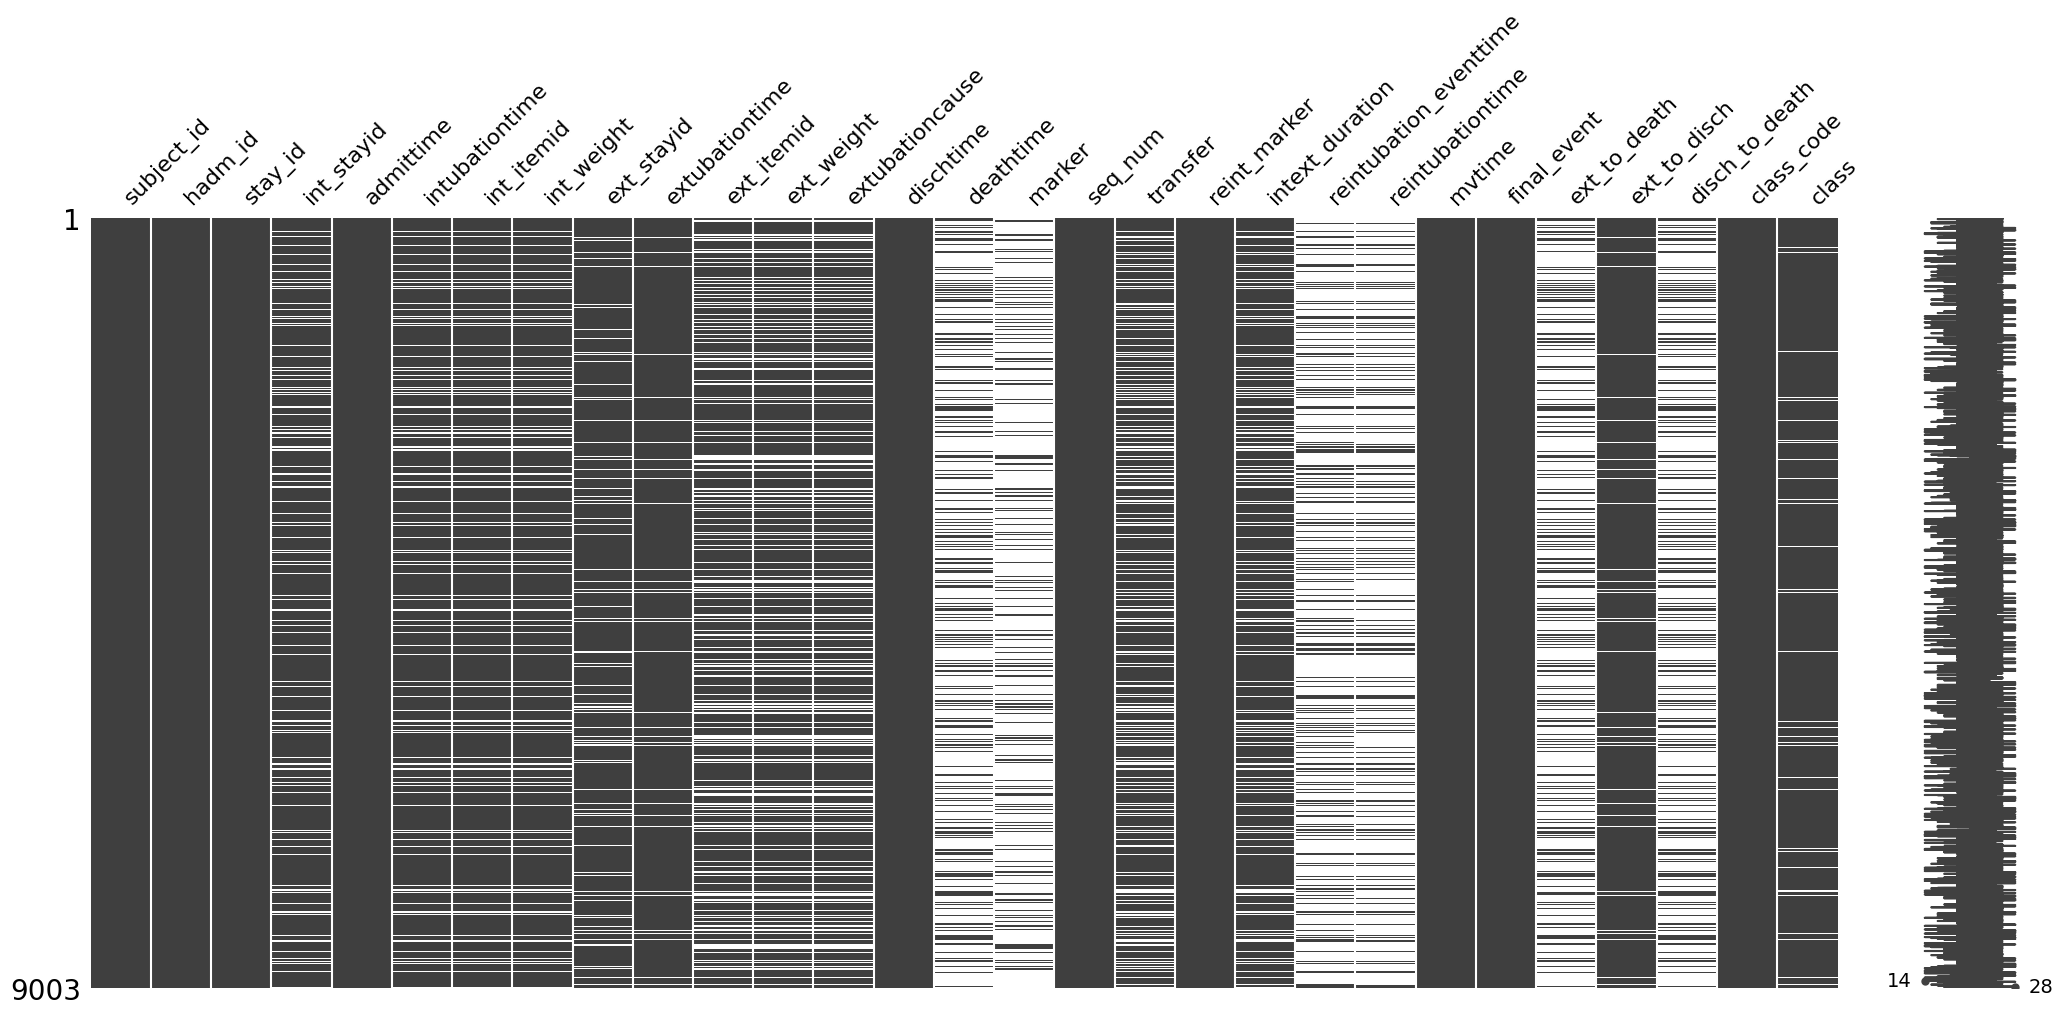

In [18]:
import missingno as msno

msno.matrix(df2)

In [9]:
multirow_candidates_list

[{'subject_id': 10020740,
  'hadm_id': 23831430,
  'candidates': [{'index': 12,
    'current_pair': {'intubationtime': NaT,
     'extubationtime': Timestamp('2150-03-12 18:15:00')},
    'candidate': ('intubationtime', Timestamp('2150-03-11 16:00:00')),
    'stay_id': 35026312},
   {'index': 13,
    'current_pair': {'intubationtime': NaT,
     'extubationtime': Timestamp('2150-03-19 11:05:00')},
    'candidate': ('intubationtime', Timestamp('2150-03-19 05:00:00')),
    'stay_id': 35044342}]},
 {'subject_id': 10024982,
  'hadm_id': 25154057,
  'candidates': [{'index': 18,
    'current_pair': {'intubationtime': NaT,
     'extubationtime': Timestamp('2203-09-28 17:00:00')},
    'candidate': ('intubationtime', Timestamp('2203-09-20 18:00:00')),
    'stay_id': 37919901}]},
 {'subject_id': 10079700,
  'hadm_id': 24239751,
  'candidates': [{'index': 47,
    'current_pair': {'intubationtime': Timestamp('2115-09-27 17:23:00'),
     'extubationtime': NaT},
    'candidate': ('extubationtime', Time

In [11]:
df[df.stay_id == 34796801]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
8407,19387278,23160199,34796801,NaN,2151-02-20 23:22:00,NaT,NaN,NaN,34796801.0,2151-02-26 15:48:00,...,NaN,2151-02-27 16:20:00,1472.0,False,False,NaN,24393.0,NaN,211,failure
8408,19387278,23160199,34796801,34796801.0,2151-02-20 23:22:00,2151-02-27 16:20:00,224385.0,95.3,34796801.0,2151-02-27 20:20:00,...,240.0,NaT,NaN,True,True,NaN,22681.0,NaN,221,nonfailure


In [ ]:
single_row_results_list, multirow_candidates_list = imp.ventilation_search(ventilation_df, paired_df)   # 후보군 추출
paired_df2 = imp.impute_candidates(paired_df, single_row_results_list, multirow_candidates_list)   # 후보군으로 결측치 대체
paired_df2 = imp.impute_null(paired_df2)   # 최종 발관시간 대체
paired_df2 = imp.mark_transfer(paired_df2)   # 병동 이동 케이스 표시 (stay_id 기준)
print(paired_df2.shape)   # (9003, 20)

NEW VERSION

In [103]:
paired_df = pd.read_csv('../outputs/paired_df.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime'])
paired_df = cls.create_stay_id(paired_df)
paired_df

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2
9004,19997367,20617667,35616526,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3
9005,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,1
9006,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1


In [60]:
paired_df.intubationtime.isna().sum()

1143

In [61]:
paired_df.extubationtime.isna().sum()

2178

In [62]:
single_row_results_list, multirow_candidates_list = imp.ventilation_search(ventilation_df, paired_df)   # 후보군 추출
paired_df2 = imp.impute_candidates(paired_df, single_row_results_list, multirow_candidates_list)   # 후보군으로 결측치 대체
paired_df2 = imp.impute_null(paired_df2)   # 최종 발관시간 대체

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철/src/subjectlist_alignment/imputation.py:274: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'extubationtime InvasiveVent imputation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'marker'] = row['marker']
Processing null data...: 100%|██████████| 6694/6694 [00:00<00:00, 9089.01it/s]


--- RUNTIME: 2.06 seconds ---


In [63]:
paired_df2.intubationtime.isna().sum()

1143

In [64]:
paired_df2.extubationtime.isna().sum()

420

In [71]:
# NEW FUNCTION

def find_missing_intubationtime(df, ventilation_df):
    missing_intubation_times = []
    
    # Group by 'hadm_id' and iterate through each group
    for hadm_id, group in df.groupby('hadm_id'):
        for idx, row in group.iterrows():
            if pd.isnull(row['intubationtime']):
                stay_id = row['stay_id']
                ventilation_events = ventilation_df[ventilation_df['stay_id'] == stay_id]

                if idx == group.index[0]:  # First row in the group
                    valid_starttimes = ventilation_events[
                        (ventilation_events['starttime'] >= row['admittime']) & 
                        (ventilation_events['starttime'] <= row['extubationtime'])
                    ]
                else:  # Not the first row, compare with previous row's extubationtime
                    prev_row = df.loc[idx - 1]
                    valid_starttimes = ventilation_events[
                        (ventilation_events['starttime'] >= prev_row['extubationtime']) & 
                        (ventilation_events['starttime'] <= row['extubationtime'])
                    ]

                # If valid starttime values are found, save them along with the index
                for starttime in valid_starttimes['starttime'].values:
                    missing_intubation_times.append({'index': idx, 'starttime': starttime})

    return missing_intubation_times


def impute_missing_intubationtime(df, missing_intubation_times):
    for item in missing_intubation_times:
        idx = item['index']
        starttime = item['starttime']
        
        # Ensure the starttime is converted to a Timestamp if not already
        if not isinstance(starttime, pd.Timestamp):
            starttime = pd.to_datetime(starttime)
        
        # Impute the missing intubationtime
        df.at[idx, 'intubationtime'] = starttime
    
    return df

In [72]:
missing_intubation_times = find_missing_intubationtime(paired_df2, ventilation_df)
paired_df3 = impute_missing_intubationtime(paired_df2, missing_intubation_times)

In [74]:
paired_df3.intubationtime.isna().sum()

960

In [67]:
missing_intubation_times

[{'index': 966,
  'starttime': numpy.datetime64('2125-08-15T17:30:00.000000000')},
 {'index': 3255,
  'starttime': numpy.datetime64('2140-01-05T08:16:00.000000000')},
 {'index': 3255,
  'starttime': numpy.datetime64('2140-01-08T12:20:00.000000000')},
 {'index': 3255,
  'starttime': numpy.datetime64('2140-01-10T23:00:00.000000000')},
 {'index': 3255,
  'starttime': numpy.datetime64('2140-01-14T10:00:00.000000000')},
 {'index': 4087,
  'starttime': numpy.datetime64('2117-01-03T12:00:00.000000000')},
 {'index': 4087,
  'starttime': numpy.datetime64('2117-01-09T15:56:00.000000000')},
 {'index': 3678,
  'starttime': numpy.datetime64('2128-08-08T22:00:00.000000000')},
 {'index': 8997,
  'starttime': numpy.datetime64('2175-09-25T15:00:00.000000000')},
 {'index': 4804,
  'starttime': numpy.datetime64('2149-03-26T15:00:00.000000000')},
 {'index': 494,
  'starttime': numpy.datetime64('2152-06-29T22:00:00.000000000')},
 {'index': 5894,
  'starttime': numpy.datetime64('2186-05-17T16:00:00.00000000

In [69]:
paired_df.iloc[383]

subject_id                    10438089
hadm_id                       28261508
stay_id                       32490594
int_stayid                         NaN
admittime          2120-02-08 00:19:00
intubationtime                     NaT
int_itemid                         NaN
int_weight                         NaN
ext_stayid                  32490594.0
extubationtime     2120-03-13 15:50:00
ext_itemid                    227194.0
ext_weight                       103.0
extubationcause     Planned Extubation
dischtime          2120-03-22 17:45:00
deathtime                          NaT
marker                             NaN
seq_num                              3
Name: 383, dtype: object

나머지는 원래 프로세스와 동일.₩

In [76]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [78]:
reintubation_df = get_reintubation(paired_df3)
print(f'Processed reintubation_df: {reintubation_df.shape}')   # (9003, 23)
reintubation_df.columns

Fetching reintubation data...: 100%|██████████| 6694/6694 [00:18<00:00, 367.21it/s]


--- RUNTIME: 19.14 seconds ---
Processed reintubation_df: (9000, 21)


Index(['subject_id', 'hadm_id', 'stay_id', 'int_stayid', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'reint_marker',
       'intext_duration', 'reintubation_eventtime', 'reintubationtime'],
      dtype='object')

In [117]:
reintubation_df.shape

(9000, 21)

In [79]:
def impute_null(df):
    """
    최종 발관시간 NULL 값 대체 후, intext_duration (삽관-발관 시간차) 계산.
    """
    start_time = time.time()   # 소요시간 계산

    df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Processing null data..."):

            patient_df = imp.impute_final_extubation(patient_df)   # 최종 발관시간이 NULL인 경우 deathtime 또는 dischtime으로 대체
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 다시 계산

            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [80]:
reintubation_df2 = impute_null(reintubation_df)
print(f'Processed reintubation_df2: {reintubation_df2.shape}')   # (9003, 23)
reintubation_df2.columns

Processing null data...: 100%|██████████| 6694/6694 [00:01<00:00, 5593.39it/s]


--- RUNTIME: 3.02 seconds ---
Processed reintubation_df2: (9000, 21)


Index(['subject_id', 'hadm_id', 'stay_id', 'int_stayid', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'reint_marker',
       'intext_duration', 'reintubation_eventtime', 'reintubationtime'],
      dtype='object')

In [81]:
reintubation_df2.intubationtime.isna().sum(), reintubation_df2.extubationtime.isna().sum()

(960, 244)

In [84]:
# 데이터 저장
reintubation_df2.to_csv('../outputs/reintubation_df2_2403.csv', encoding='utf-8-sig')

In [5]:
reintubation_df2 = pd.read_csv('../outputs/reintubation_df2_2403.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', \
                                                                 'dischtime', 'deathtime', 'reintubation_eventtime'])

reintubation_df2

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num,reint_marker,intext_duration,reintubation_eventtime,reintubationtime
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1,False,2230.0,NaT,NaN
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1,False,5419.0,NaT,NaN
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1,False,3477.0,NaT,NaN
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1,True,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2,True,10005.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2,True,8416.0,2126-05-05 18:20:00,4430.0
8996,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3,True,4269.0,NaT,NaN
8997,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,1,False,4201.0,NaT,NaN
8998,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1,False,1155.0,NaT,NaN


In [6]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [7]:
subjectlist1 = categorize_patients(reintubation_df2)

# stayid_mismatch 칼럼 생성
subjectlist1 = utils.mark_stayid_mismatch(subjectlist1)   # 삽관 발관 이벤트의 stay_id가 안 맞는 케이스를 마킹함.
# subjectlist1 = util.create_stay_id(subjectlist1)   # 'stay_id' 칼럼 생성


subjectlist2 = subjectlist1[subjectlist1.mvtime == False]   # mvtime 제거

print(f'Processed subjectlist1: {subjectlist1.shape}')   # (9003, 31)
print(f'Processed subjectlist2: {subjectlist2.shape}')   # (6535, 31)

subjectlist1.columns

Categorizing extubation failure vs non-failure...:   0%|          | 0/6694 [00:00<?, ?it/s]

Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:13<00:00, 479.96it/s]


--- RUNTIME: 15.33 seconds ---
Processed subjectlist1: (9000, 29)
Processed subjectlist2: (6463, 29)


Index(['subject_id', 'hadm_id', 'stay_id', 'int_stayid', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'reint_marker',
       'intext_duration', 'reintubation_eventtime', 'reintubationtime',
       'mvtime', 'final_event', 'ext_to_death', 'ext_to_disch',
       'disch_to_death', 'class_code', 'class', 'stayid_mismatch'],
      dtype='object')

In [89]:
# 결측치 대체하지 않고 환자 분류
reintubation_df_original = get_reintubation(paired_df)
subjects_df_original = categorize_patients(reintubation_df_original)

# 결측치 대체하지 않았을 때 데이터 손실율 계산 (Original Loss)
code_valuecount_original = subjects_df_original.class_code.value_counts()
not_classified_count = code_valuecount_original[9999]
total_count =  code_valuecount_original.sum()

# 결측치 대체 후 데이터 손실율 계산 (Adjusted Loss)
code_valuecount = subjectlist1.class_code.value_counts()
not_classified = code_valuecount[9999]
total_count =  code_valuecount.sum()


print('------------------------------------------------')
print('DATA LOSS CHANGE:')
print(f'Original Loss')
print(f'{not_classified_count} / {total_count} ({round(not_classified_count/total_count * 100, 2)}%)')
print('')
print(f'Adjusted Loss')
print(f'{not_classified} / {total_count} ({round(not_classified/total_count * 100, 2)}%)')

Fetching reintubation data...: 100%|██████████| 6694/6694 [00:18<00:00, 367.72it/s]


--- RUNTIME: 19.15 seconds ---


Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:13<00:00, 499.78it/s]


--- RUNTIME: 14.95 seconds ---
------------------------------------------------
DATA LOSS CHANGE:
Original Loss
946 / 9000 (10.51%)

Adjusted Loss
151 / 9000 (1.68%)


In [8]:
subjectlist1.intubationtime.isna().sum(), subjectlist1.extubationtime.isna().sum()

(960, 244)

In [91]:
# 데이터 저장
sub1list = subjectlist1 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub1list = sub1list.drop_duplicates(subset='stay_id')   # remove dup


sub2list = subjectlist2 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list = sub2list.drop_duplicates(subset='stay_id')   # remove dup


subjectlist1.to_csv('../outputs/subjectlist1_intextevents.csv')   # 삽관발관 포함
subjectlist2.to_csv('../outputs/subjectlist2_intextevents.csv')   # 삽관발관 포함
sub1list.to_csv('../outputs/sub1list.csv')   # 고유 환자리스트
sub2list.to_csv('../outputs/sub2list.csv')   # 고유 환자리스트



<Axes: >

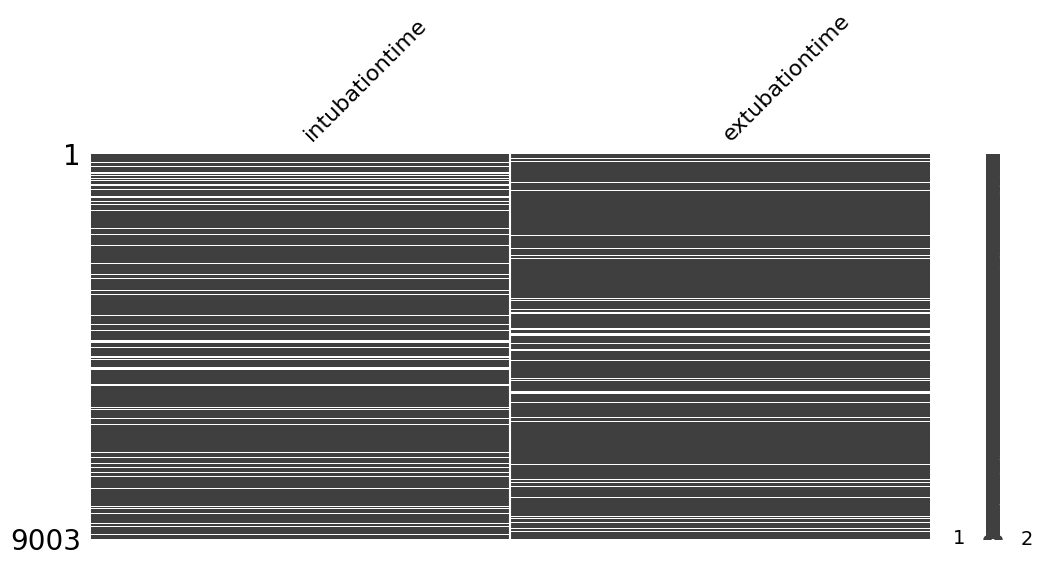

In [92]:
msno.matrix(paired_df[['intubationtime', 'extubationtime']], figsize=(12,5))

<Axes: >

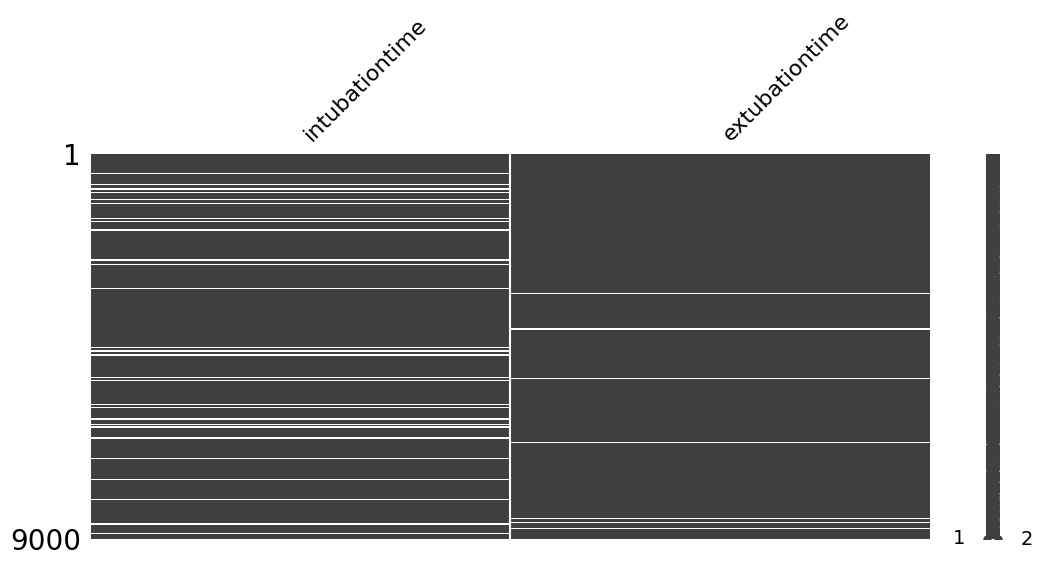

In [93]:
msno.matrix(subjectlist1[['intubationtime', 'extubationtime']], figsize=(12,5))

In [94]:
subject_count = sub1list.subject_id.nunique()   # 환자 수

print(f'UNIQUE SUBJECTS: {subject_count}')
print(subjectlist1.class_code.value_counts())
print(f'SUM: {subjectlist1.class_code.value_counts().sum()}')

UNIQUE SUBJECTS: 6342
class_code
11       3614
211      1175
221       991
1221      989
212       858
2221      375
22221     354
121       259
9999      151
998        95
1222       80
22222      32
999        27
Name: count, dtype: int64
SUM: 9000


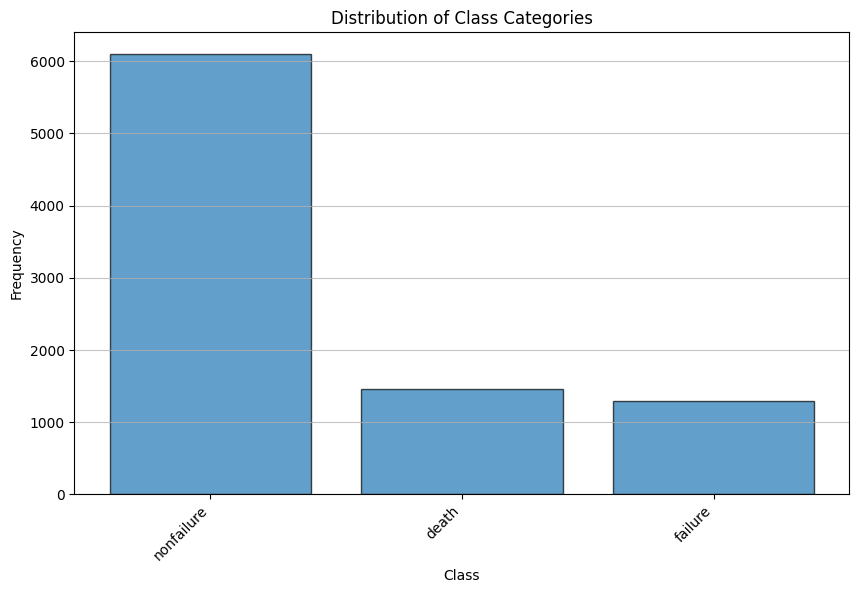

class
nonfailure    6097
death         1455
failure       1297
Name: count, dtype: int64
TOTAL: 8849


In [97]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjectlist1['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

In [98]:
def calculate_null_ratios_summary(df):
    # Group by 'hadm_id' and calculate null ratios for each group
    null_ratios = df.groupby('hadm_id').apply(lambda group: {
        'intubationtime_null_ratio': group['intubationtime'].isnull().mean(),
        'extubationtime_null_ratio': group['extubationtime'].isnull().mean()
    })

    # Convert the Series of dictionaries into a DataFrame
    null_ratios_df = pd.DataFrame(list(null_ratios), index=null_ratios.index)
    
    # Calculate summary statistics for each ratio
    summary_stats = {
        'intubationtime': {
            'average': null_ratios_df['intubationtime_null_ratio'].mean(),
            'std_dev': null_ratios_df['intubationtime_null_ratio'].std(),
            'range': (null_ratios_df['intubationtime_null_ratio'].min(), null_ratios_df['intubationtime_null_ratio'].max())
        },
        'extubationtime': {
            'average': null_ratios_df['extubationtime_null_ratio'].mean(),
            'std_dev': null_ratios_df['extubationtime_null_ratio'].std(),
            'range': (null_ratios_df['extubationtime_null_ratio'].min(), null_ratios_df['extubationtime_null_ratio'].max())
        }
    }

    return summary_stats

In [104]:
calculate_null_ratios_summary(paired_df)

{'intubationtime': {'average': 0.07326959466188626,
  'std_dev': 0.1744922294689711,
  'range': (0.0, 0.75)},
 'extubationtime': {'average': 0.2591549646449557,
  'std_dev': 0.41516249396680105,
  'range': (0.0, 1.0)}}

In [108]:
def calculate_null_counts_summary(df):
    # Group by 'hadm_id' and calculate the count of nulls for each group
    null_counts = df.groupby('hadm_id').apply(lambda group: {
        'intubationtime_null_count': group['intubationtime'].isnull().sum(),
        'extubationtime_null_count': group['extubationtime'].isnull().sum()
    })

    # Convert the Series of dictionaries into a DataFrame
    null_counts_df = pd.DataFrame(list(null_counts), index=null_counts.index)
    
    # Calculate summary statistics for each count
    summary_stats = {
        'intubationtime': {
            'average': null_counts_df['intubationtime_null_count'].mean(),
            'std_dev': null_counts_df['intubationtime_null_count'].std(),
            'range': (null_counts_df['intubationtime_null_count'].min(), null_counts_df['intubationtime_null_count'].max())
        },
        'extubationtime': {
            'average': null_counts_df['extubationtime_null_count'].mean(),
            'std_dev': null_counts_df['extubationtime_null_count'].std(),
            'range': (null_counts_df['extubationtime_null_count'].min(), null_counts_df['extubationtime_null_count'].max())
        }
    }

    return summary_stats

calculate_null_counts_summary(paired_df)


{'intubationtime': {'average': 0.1707499253062444,
  'std_dev': 0.41592259911293067,
  'range': (0, 3)},
 'extubationtime': {'average': 0.32536599940245,
  'std_dev': 0.5091942427274231,
  'range': (0, 3)}}

In [107]:
paired_df.intubationtime.isna().sum()

1143

In [111]:
subjectlist1.intext_duration.min(), subjectlist1.intext_duration.max()

(-1129.0, 237308.0)

In [9]:
filtered_sl = subjectlist1[(subjectlist1.intext_duration >= 0)]
filtered_sl

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
8996,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,NaT,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
8997,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,NaT,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
8998,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,NaT,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [122]:
filtered_sl.intext_duration.mean() / 60

106.6982180293501

In [28]:
filtered_sl.intext_duration.median() / 60

49.416666666666664

In [128]:
filtered_sl.intext_duration.std() / 60

182.06907712486026

In [126]:
filtered_sl.intext_duration.min() / 60

0.03333333333333333

In [14]:
filtered_sl.intext_duration.max() / 60

3955.133333333333

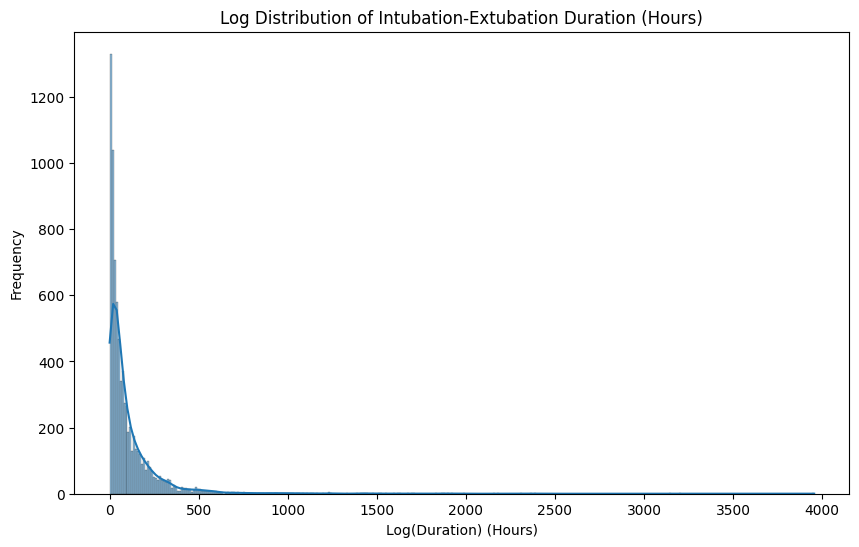

In [15]:


# Plotting the distribution of the log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_sl['intext_duration'] / 60, kde=True)
plt.title('Log Distribution of Intubation-Extubation Duration (Hours)')
plt.xlabel('Log(Duration) (Hours)')
plt.ylabel('Frequency')
plt.show()

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_60377/698836893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sl['log_intext_duration_hours'] = np.log(filtered_sl['intext_duration'] / 60 + 1)  # Adding 1 to avoid log(0)


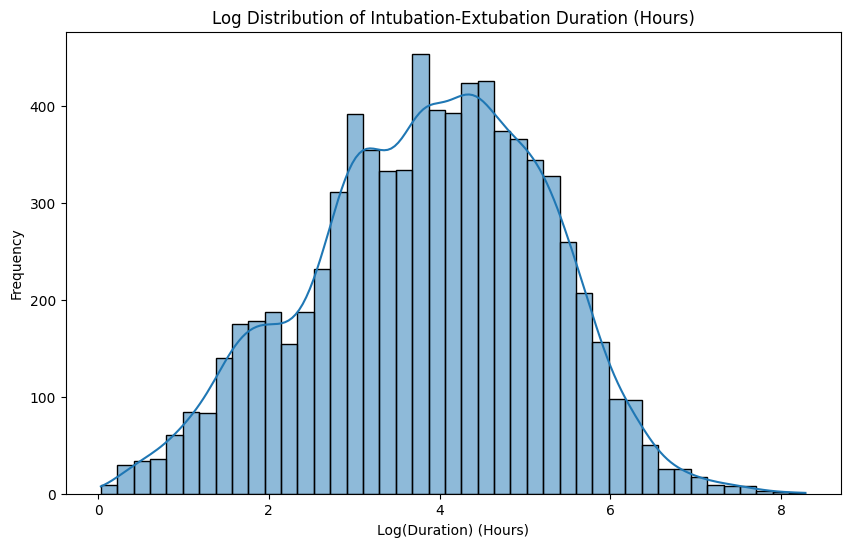

In [11]:
filtered_sl['log_intext_duration_hours'] = np.log(filtered_sl['intext_duration'] / 60 + 1)  # Adding 1 to avoid log(0)

# Plotting the distribution of the log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_sl['log_intext_duration_hours'], kde=True)
plt.title('Log Distribution of Intubation-Extubation Duration (Hours)')
plt.xlabel('Log(Duration) (Hours)')
plt.ylabel('Frequency')
plt.show()

In [27]:
filtered_sl[filtered_sl.intext_duration / 60 / 24 > 40].shape

(57, 30)

In [38]:
(subjectlist1.reintubationtime < 5).sum()

31

In [39]:
(subjectlist1.reintubationtime < 0).sum()

7

In [43]:
subjectlist1_new = subjectlist1[~(subjectlist1.reintubationtime < 0)]
subjectlist1_new

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
8996,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,NaT,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
8997,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,NaT,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
8998,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,NaT,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [57]:
subjectlist1_new[subjectlist1_new.intext_duration > 0]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
8996,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,NaT,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
8997,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,NaT,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
8998,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,NaT,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [44]:
subjectlist1_new[subjectlist1_new.reintubationtime <=5]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
189,10236222,23831668,38663094,NaN,2199-12-21 20:20:00,NaT,NaN,NaN,38663094.0,2200-01-01 22:25:00,...,2200-01-01 22:26:00,1.0,False,False,2513.0,2513.0,0.0,211,failure,False
804,10886970,26397173,34472501,34472501.0,2144-07-20 21:43:00,2144-07-25 05:30:00,224385.0,69.0,34472501.0,2144-07-25 09:30:00,...,2144-07-25 09:31:00,1.0,True,False,NaN,25010.0,NaN,211,failure,False
941,11020202,27311676,31621601,31621601.0,2121-03-05 19:20:00,2121-03-06 14:15:00,224385.0,105.0,31621601.0,2121-03-19 14:45:00,...,2121-03-19 14:50:00,5.0,False,False,NaN,12823.0,NaN,211,failure,False
942,11020202,27311676,31621601,31621601.0,2121-03-05 19:20:00,2121-03-19 14:50:00,224385.0,105.0,31621601.0,2121-03-20 04:35:00,...,2121-03-20 04:40:00,5.0,True,False,NaN,11993.0,NaN,211,failure,False
1319,11455001,21859241,35214382,35214382.0,2135-08-03 08:00:00,2135-08-11 03:00:00,224385.0,100.0,35214382.0,2135-08-13 21:40:00,...,2135-08-13 21:44:00,4.0,False,False,NaN,14030.0,NaN,211,failure,False
1399,11551927,29654387,38006137,38006137.0,2171-05-05 18:36:00,2171-05-10 13:00:00,224385.0,92.0,38006137.0,2171-05-12 10:50:00,...,2171-05-12 10:54:00,4.0,False,False,NaN,44910.0,NaN,211,failure,False
1420,11570331,26919892,30916265,30916265.0,2134-12-28 04:51:00,2134-12-29 09:00:00,224385.0,92.4,30916265.0,2134-12-29 14:57:00,...,2134-12-29 15:02:00,5.0,True,False,11261.0,11261.0,0.0,211,failure,False
1654,11871434,24994500,31855550,31855550.0,2142-11-19 15:16:00,2142-11-23 06:55:00,224385.0,80.0,31855550.0,2142-11-24 15:23:00,...,2142-11-24 15:23:00,0.0,False,False,NaN,15937.0,NaN,211,failure,False
1974,12206800,23249668,33767986,33767986.0,2148-12-04 14:24:00,2148-12-04 19:11:00,224385.0,48.1,33767986.0,2148-12-10 22:10:00,...,2148-12-10 22:13:00,3.0,False,False,NaN,31250.0,NaN,211,failure,False
2107,12362110,27218756,36646479,NaN,2119-06-13 21:48:00,NaT,NaN,NaN,36646479.0,2119-06-15 13:15:00,...,2119-06-15 13:20:00,5.0,False,False,NaN,16180.0,NaN,211,failure,False


In [46]:
subjectlist1_new.intubationtime.isna().sum(), subjectlist1_new.extubationtime.isna().sum()

(960, 244)

In [48]:
subjectlist1_new.intubationtime.isna().sum()

960

In [49]:
subjectlist1_new.shape

(8993, 29)

In [50]:
# Calculate the data imbalance for the given pairs
imbalance1 = 7860 / 6825
imbalance2 = 8033 / 8749

imbalance1, imbalance2

(1.1516483516483516, 0.9181620756657903)

In [52]:
paired_df.intubationtime.notna().sum(), paired_df.extubationtime.notna().sum()

(7860, 6825)

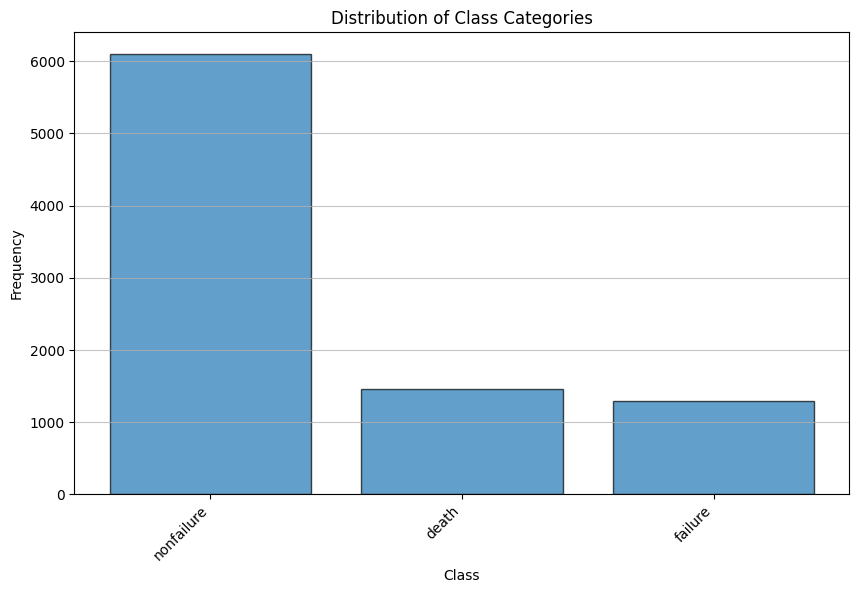

class
nonfailure    6097
death         1455
failure       1290
Name: count, dtype: int64
TOTAL: 8842


In [53]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjectlist1_new['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

<Axes: >

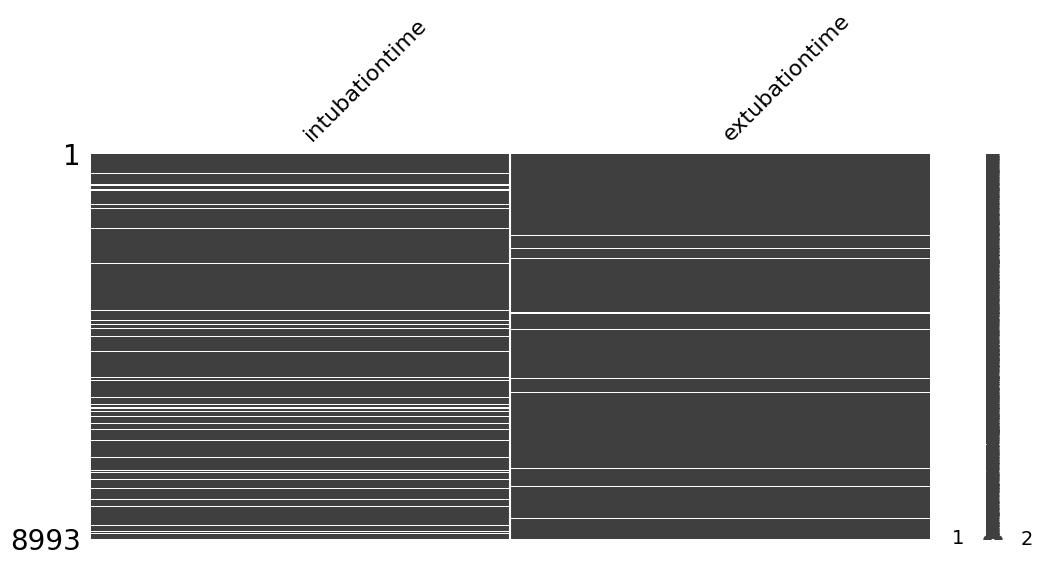

In [54]:
msno.matrix(subjectlist1_new[['intubationtime', 'extubationtime']], figsize=(12,5))